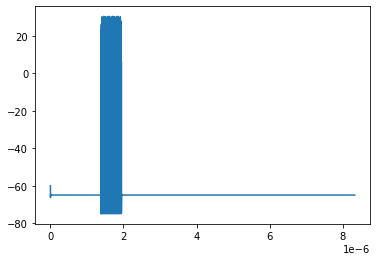

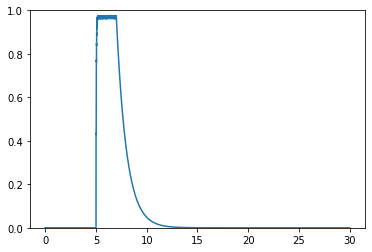

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

from numba import njit, jit

## HH Model. 

##Function of rate constant increase of m.
@njit
def alpha_m(Vm):
   return 0.1*(Vm + 40.0)/(1.0 - np.exp( - (Vm + 40.0)/10.0))

##Function of rate constant decrease of m.
@njit
def beta_m(Vm):
   return 4.0*np.exp( - (Vm + 65.0)/18.0) 

##Function of rate constant increase of h.
@njit
def alpha_h(Vm):
   return 0.07 * np.exp( - (Vm + 65.0)/20.0)

##Function of rate constant decrease of h.
@njit
def beta_h(Vm):
   return 1.0/(1.0 + np.exp( - (Vm + 35.0)/10.0))
   
##Function of rate constant increase of n. 
@njit
def alpha_n(Vm):
  return 0.01 * (Vm + 55.0)/(1.0 - np.exp( - (Vm + 55.0)/10.0))

##Function of rate constant decrease of n.
@njit
def beta_n(Vm):
  return 0.125 * np.exp( - (Vm + 65)/80.0)

## Function of sodium channel current (mA/cm^2). 
@njit
def I_Na(m, h, Vm):
  g_Na = 120.0  # maximum sodium conductance (mS/cm^2)
  E_Na = 50.0  # sodium reversal potential (mV)
  return g_Na*(m**3)*h*(Vm - E_Na)

##Function of potassium channels current (mA/cm^2).
@njit
def I_K(n, Vm):
  E_K = -77.0  # potassium reversal potential (mV)
  g_K = 36.0  # maximum potassium conductance (mS/cm^2)
  return g_K*(n**4)*(Vm - E_K)

##Function of leakage current (mA/cm^2).
@njit
def I_L(Vm):
  g_L = 0.3  # maximum leak conductance (mS/cm^2)
  E_L = -54.4  # leak reversal potential (mV)
  return g_L*(Vm - E_L)
  
##Function of AMPA current (mA/cm^2). 
@njit
def  I_AMPA(g_AMPA, Vm):
  E_AMPA = 0.0 #Reversal potential for AMPA channels (mV)
  return g_AMPA*(Vm - E_AMPA)

##Function of magnesium block of NMDA dependent on voltage (mV).
@njit
def MgB(Vm):
  Mg0 = 2 #mM
  return 1/(1 + (Mg0 * np.exp(-0.062*Vm))/3.57)


##Function of NMDA channel sodium current density (mA/cm^2)
@njit
def I_NMDA_Na(g_NMDA, Vm):
  P_Na = 1 #Permeability ratio to sodium. 
  c = 0.1 #Conversor A/m^2 -> mA/cm^2 
  P_NMDA = 10*10**(-9) #m/s
  F = 96485 #C/mol 
  R = 8.314 #J/K*mol
  T = 308.15 #K
  Nai = 18 #mM
  Nao = 140 #mM
  V_lim = 100 #mV
  a1 = g_NMDA * c * P_NMDA * P_Na * MgB(Vm) * ((Vm/1000 * F**2)/(R*T))
  a2 = Nai if Vm > V_lim else Nao if Vm < -V_lim else ((Nai - Nao * np.exp(-((Vm/1000 * F)/(R*T))))/(1 - np.exp(-((Vm/1000 * F)/(R*T)))))

  I = a1*a2
 
  return I

##Function of NMDA channel potassium current density (mA/cm^2)
@njit
def I_NMDA_K(g_NMDA, Vm):
  P_K = 1 #Permeability ratio to potassium. 
  c = 0.1 #Conversor A/m^2 -> mA/cm^2 
  P_NMDA = 10*10**(-9) #m/s
  F = 96485 #C/mol 
  R = 8.314 #J/K*mol
  T = 308.15 #K
  Ki = 140 #mM
  Ko = 5 #mM
  V_lim = 100 #mV
  a1 = g_NMDA * c * P_NMDA * P_K * MgB(Vm) * ((Vm/1000 * F**2)/(R*T))
  a2 = Ki if Vm > V_lim else Ko if Vm < -V_lim else ((Ki - Ko * np.exp(-((Vm/1000 * F)/(R*T))))/(1 - np.exp(-((Vm/1000 * F)/(R*T)))))
  I = a1*a2

  return I

  
##Function of NMDA channel calcium current density (mA/cm^2).
@njit
def I_NMDA_Ca(g_NMDA, Vm): 
  P_Ca = 10.6 #Permeability ratio to calcium. 
  c = 0.1 #Conversor A/m^2 -> mA/cm^2 
  P_NMDA = 10*10**(-9) #m/s
  F = 96485 #C/mol 
  R = 8.314 #J/K*mol
  T = 308.15 #K
  Cai = 0.0001 #mM
  Cao = 2 #mM
  V_lim = 100 #mV
  a1 =  g_NMDA * c * P_NMDA * P_Ca * MgB(Vm) * ((4*Vm/1000 * F**2)/(R*T))
  a2 = Cai if Vm > V_lim else Cao if Vm < -V_lim else ((Cai - Cao * np.exp(-((2*Vm/1000 * F)/(R*T))))/(1 - np.exp(-((2*Vm/1000 * F)/(R*T)))))
  I = a1*a2

  return I


##Function of total NMDA channel current density (mA/cm^2).
@njit
def I_NMDA(g_NMDA, Vm):
  return I_NMDA_Na(g_NMDA, Vm) + I_NMDA_K(g_NMDA, Vm) + I_NMDA_Ca(g_NMDA, Vm)


##Function of inward calcium rate (uM/ms).
@njit
def inward_Ca(g_NMDA, Vm):
  F = 96485 # Faraday Constant (mA*ms/umol). 
  d = 8.4e-6 #Distance of membrane shell where calcium ions enter (cm).  
  c = 1000 #conversor umol/(cm^3 * ms) to uM/ms. 
  return - c * I_NMDA_Ca(g_NMDA, Vm)/(2*F*d)

##Function of outward calcium rate (uM/ms).
@njit
def outward_Ca(Cai):
  Cai_eq = 0
  c = 0.1 #Rate of calcium pump buffering (ms^-1).
  return + c * (Cai - Cai_eq)

##Function of GABA A current (mA/cm^2).
@njit
def I_GABA_A(g_GABA_A, Vm):
  E_GABA_A = -70.0 #Reversal potential for GABA A channels (mV).
  return g_GABA_A * (Vm - E_GABA_A)
  
##Function of GABA B current (mA/cm^2).
@njit
def I_GABA_B(g_GABA_B, Vm):
  E_GABA_B = -95.0 #Reversal potential for GABA B channels (mV).
  return g_GABA_B*(Vm - E_GABA_B)/(1.0 + np.exp(-(Vm + 80.0)/25.0))

##Function of external current (mA/cm^2)
@njit
def I_ext(t):
  if t>= 5000/3600000 and t<=7000/3600000: #stimulation period: 2000ms
    I=10 #350uA emitted by the probe, but bcs of surface area, cell should experience more current than that
  else:
    I = 0
  return I

#define whether neuron is firing (1) and not firing (0) at a certain time point
@njit
def spike_boolean(Vm):
  Vth = 0
  return 1 if Vm >= Vth else 0

## ODE model

def comp_model(t, y, th):
  # Parameters of HH model
  C_m = 1.0  # membrane capacitance (uF/cm^2)

  # Define Poisson input parameters
  rate = 0*2*(1/100)  # firing rate (ms-1). 
  w_NMDA = 8
  w_GABA_A = 1
  w_AMPA = 8
  w_GABA_B = 1
  # w1 = 0.75  # Excitatory noise synaptic weight
  # w2 = 0.2 #Inhibitory noise synaptic weight
 

#conductance at baseline, unit: mS
  g_AMPA = w_AMPA * np.random.poisson(rate, 1) 
  g_GABA_A = w_GABA_A * np.random.poisson(rate, 1)
  g_NMDA = w_NMDA * np.random.poisson(rate, 1) 
  g_GABA_B = w_GABA_B * np.random.poisson(rate, 1) 

  spike = spike_boolean(y[0])
  w1 = 0.5
  w2 = 0.001 
  #Initialize differential list. 
  dy = np.zeros(6)

  #Variable in ODE. 
  #y[0] = Vm, membrane potential of neurons. 
  #y[1] = m, activation gating variable for the voltage-gated sodium (Na+) channels.
  #y[2] = h, activation gating variable for the voltage-gated potassium (K+) channels.
  #y[3] = n, Inactivation gating variable for the Na+ channels.
  #y[4] = Cai, internal calcium concentration (uM).
  #y[5] = activity.


  #Differential equations
  dy[0] = (- I_Na(y[1], y[2], y[0]) - I_K(y[3], y[0]) - I_L(y[0]) - I_AMPA(g_AMPA, y[0]) - I_NMDA(g_NMDA, y[0]) - I_GABA_A(g_GABA_A, y[0]) - I_GABA_B(g_GABA_B, y[0]) + I_ext(t))/C_m
  dy[1] = alpha_m(y[0])*(1.0 - y[1]) - beta_m(y[0])*y[1]
  dy[2] = alpha_h(y[0])*(1.0 - y[2]) - beta_h(y[0])*y[2]
  dy[3] = alpha_n(y[0])*(1.0 - y[3]) - beta_n(y[0])*y[3]
  dy[4] = inward_Ca(g_NMDA, y[0]) - outward_Ca(y[4])
  dy[5] = w1 * spike * (1 - y[5]) - w2 * y[5]
  
  #Change from ms -> h
  dy = dy*3600000 #(h-1)

  return dy



#Constant parameters

random_seed = 25 #Seed of the pseudo-random number generator. 
np.random.seed(random_seed)


#Time array.
t_factor = 3600000 # Time factor for graphs (1 for ms).
time = 30*1000/t_factor # Time of simulation depending on t_factor.
sampling_rate = 1*t_factor #number of samples per time factor units.
time_array = np.linspace(0, time, math.floor(time * sampling_rate + 1))
th = time_array[1] - time_array[0] #Time interval between samples.




#Initial conditions with their original shapes. 
Vm = -60 #Membrane potential. 
m = 0.05  #Activation gating variable for the voltage-gated sodium (Na+) channels.
h = 0.6  #Activation gating variable for the voltage-gated potassium (K+) channels.
n = 0.32  #Inactivation gating variable for the Na+ channels.
Ca_0 = 0 #Internal calcium. 
activity = 0 #Activity of neuron. 


y0 = [Vm, m, h, n, Ca_0, activity] #Flatten initial conditions.



#Get solution of the differential equation.
sol = solve_ivp(comp_model, t_span = (time_array[0], time_array[-1]), t_eval = time_array, y0 = y0, method = 'RK45', args = (th,))

## Additional: Solution of the equation with custom RK45 with fixed step size. 

#Get results
y = sol.y

plt.figure()
plt.plot(time_array*3600/sampling_rate, y[0])

plt.figure()
plt.plot(time_array*3600, y[5])
plt.ylim([0,1])
plt.show()